# Two deep learning methods for Black-Scholes Model

The Black-Scholes PDE plays a significant role in option trading. It was discovered by Fischer Black and Myron Scholes (McMaster grad!), which won them the 1997 Nobel Prize in Economics. This equation is amazing because it shows a function (stock option) over something random in nature (stocks), is deterimistic over time (with a little bit of additional assumptions)!

We will study valuation of the European call option under Black-Scholes model in 2 dimension (time and stock price). The other usual option parameter such as maturity time, stock volatility and discount interest rate will be fixed.

In [1]:
# Import Packages
from IPython.display import clear_output
from time import sleep

import pathlib
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
from scipy.stats import norm
import matplotlib.pyplot as plt

# Set fixed option global parameters
k = 100
sigma = 0.4
r = 0.05
T = 1

The Black-Scholes PDE for European call option is:
\begin{align}
\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2s^2\frac{\partial^2 V}{\partial s^2}+rs\frac{\partial V}{\partial s}-rV(t,s)=0,
\\
max(s-k, 0),\quad\text{when}\quad t=T.\quad\text{terminal condition}
\\
V(t,s)=0,\quad\text{for $s=0$}.\quad\text{boundry condition}
\\
V(t,s)=s,\quad\text{as $s\to\infty$}.\quad\text{asymptotic condition}
\end{align}

Through a little theorem called Feynman-Kac, the solution of the above PDE can also be expressed as:

\begin{align}
V(t,s) = e^{-r(T-t)}\mathbb{E}\big[max(S(T)-k,0)|S(t)=s\big].
\end{align}

There exists an analytical solution, it has the form:

\begin{align}
V(t,s) = s\Phi(d_1)-e^{-r(T-t)}k\Phi(d_2),\quad\text{where}
\\
d_1 = \frac{\log(s/k)+(\frac{\sigma^2}{2}+r)(T-t)}{\sigma\sqrt{T-t}},\text{ and }d_2 = d_1-\sigma\sqrt{T-t}.
\end{align}

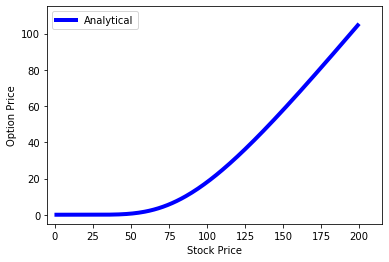

In [2]:
# Analytical solution

def BS_Call_Price(S, t):
    d1 = (np.log(S/k) + (r+sigma**2/2)*(T-t))/(sigma*np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)
       
    price = S * norm.cdf(d1)- k * np.exp(-r*(T-t)) * norm.cdf(d2)
    return price

def plot_ana():
    B = []
    index = []
    for i in range(1,200):
        index.append(i)
        B.append(BS_Call_Price(i, 0))
    
    plt.plot(index, B, color="blue", label='Analytical', linewidth=4)
    plt.xlabel('Stock Price')
    plt.ylabel('Option Price')
    plt.xlim([-5, 215]) 
    plt.ylim([-5, 115]) 
    plt.legend()
    plt.show()

plot_ana()

# Case study 1 - with data generated from base model
At an option trading firm, we want to speed up our existing pricing library with deep learning. A good place to start is the Black-Scholes model. We may generate data with the analytical solution for the purpose of building a deep learning version ultimately. Depending on the preformance of our deep learning model, we may decide to partake or abandon this project.

In [3]:
def create_test_value(num_of_test_values):
   
    output = []
     
    for i in range(0, num_of_test_values):
        S = random.uniform(1, 200)
        t = random.uniform(0, 1)
       
        output.append([])
       
        output[i].append(BS_Call_Price(S, t))
        output[i].append(t)
        output[i].append(S)
        
       
    return output

headers=['Option Price', 'Time', "Stock Price"]
raw_dataset = pd.DataFrame(create_test_value(10000), columns=headers)

print("__________________________________________________________________")
print(raw_dataset.head(5))
print("__________________________________________________________________")

__________________________________________________________________
   Option Price      Time  Stock Price
0  5.139583e+01  0.820036   150.453252
1  9.763979e+01  0.602673   195.640576
2  6.973789e+01  0.882251   169.150649
3  2.014362e-12  0.513046    13.893358
4  9.446953e-05  0.614509    36.112774
__________________________________________________________________


Before training, we must split the data into a set delicated for training and another dedicated for testing the trained model. We also need to create the labels, which is just a fancy term for the variable you are interested in predicting. In our case, the label would be option price.

In [4]:
dataset = raw_dataset.copy()

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('Option Price')
test_labels = test_dataset.pop('Option Price')
print("__________________________________________________________________")
print(train_labels.head(5))
print("__________________________________________________________________")

__________________________________________________________________
9394    5.223283e-21
898     2.925249e+00
2398    1.210735e-02
5906    2.541123e-30
2343    1.789564e-01
Name: Option Price, dtype: float64
__________________________________________________________________


Now we can build the network! I choosed to used a relatively small one because it will run fast :)

In [5]:
def build_model(num_n):
    model = keras.Sequential([
    layers.Dense(num_n, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(num_n, activation=tf.nn.relu),
    layers.Dense(num_n, activation=tf.nn.relu),
    layers.Dense(num_n, activation=tf.nn.relu),
    layers.Dense(1)
  ])

    optimizer = tf.optimizers.Adam(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

model = build_model(64)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 12,737
Trainable params: 12,737
Non-trainable params: 0
_________________________________________________________________


Create some ways of visualizing your predictive capabilities

In [6]:
class MyCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 2 == 0:
            clear_output(wait=True)
            model_show_predict()
            print("Epoch: " + str(epoch + 2))
            sleep(1)

def model_show_predict():

    B = []
    index = []
    for i in range(1,200):
        index.append(i)
        B.append(BS_Call_Price(i, 0))
    
    S= tf.Variable(np.reshape(np.linspace(1,199,num=199),(199,1)), dtype = 'float32')
    t = tf.Variable(np.zeros(shape=(199,1)), dtype = 'float32')
    
    X_test = tf.concat([t, S], axis = 1)
    
    DD = model(X_test)

    plt.plot(index, B, color="blue", label='Analytical', linewidth=4)
    plt.plot(index, DD, color="red", label='NN1', linestyle='dashed', linewidth=3)
    plt.xlabel('Stock Price')
    plt.ylabel('Option Price')
    plt.xlim([-5, 215]) 
    plt.ylim([-5, 115]) 
    plt.legend()
    plt.show()

We will set EPOCHS=300 and start training now,

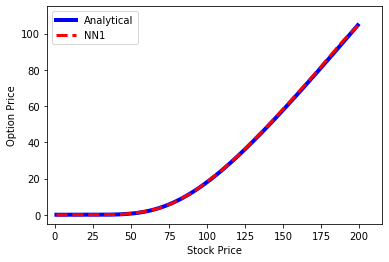

Epoch: 50
        loss       mae       mse  val_loss   val_mae   val_mse  epoch
45  2.012490  0.870448  2.012490  0.090706  0.211966  0.090706     45
46  0.174487  0.262748  0.174487  0.058813  0.180645  0.058813     46
47  0.172273  0.271021  0.172273  0.389935  0.497663  0.389935     47
48  0.390467  0.364739  0.390467  0.164300  0.274212  0.164300     48
49  0.582507  0.429776  0.582507  0.161368  0.271693  0.161368     49
Testing set Mean Abs Error:  0.27 Option Price


In [7]:
def train_model_1():
    EPOCHS = 50

    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

    history = model.fit(train_dataset, train_labels, epochs=EPOCHS,
                        validation_split = 0.2, verbose=0, callbacks=[early_stop, MyCallback()])



    loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=0)

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    print(hist.tail())
    print("Testing set Mean Abs Error: {:5.2f} Option Price".format(mae))

train_model_1()

# Case study 2 - without data from base model
Now suppose we just have the Black-Scholes PDE for European option, we don't know it has an analytical solution. Can we still solve it with deep learning? The answer is yes! Once again, the PDE is:
\begin{align}
\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2s^2\frac{\partial^2 V}{\partial s^2}+rs\frac{\partial V}{\partial s}-rV(t,s)=0,
\\
max(s-k, 0),\quad\text{when}\quad t=T.\quad\text{terminal condition}
\\
V(t,s)=0,\quad\text{for $s=0$}.\quad\text{boundry condition}
\\
V(t,s)=s,\quad\text{as $s\to\infty$}.\quad\text{asymptotic condition}
\end{align}

The trick is to assume a neural network can be accurately calibrated into the function $V(t,s)$. We will continuously sample points in the domain of $V$, then keep using the samples to calibrate our network!

We build a new network, with a custom Loss function for Solving PDEs!

In [10]:
def build_pde_model(num_n):
    model = keras.Sequential([
    layers.Dense(num_n, activation=tf.nn.softplus),
    layers.Dense(num_n, activation=tf.nn.softplus),
    layers.Dense(num_n, activation=tf.nn.softplus),
    layers.Dense(1)
  ])
    return model

pde_model = build_pde_model(128)


def generate_batch(batch_size):   
    cap = 300 
    
    # generate a point in the interior
    S = tf.Variable(np.random.beta(6,10, size=[batch_size, 1])*cap, dtype = 'float32')
    t = tf.Variable(np.random.uniform(0, T, size=[batch_size, 1]), dtype = 'float32')
    
    # generate a point on the boundary
    S_bound1 = tf.Variable(cap * np.ones(shape=[int(batch_size/2),1]), dtype = 'float32')
    T_bound1 = tf.Variable(np.random.uniform(0,T,size=[int(batch_size/2), 1]), dtype = 'float32')
    X_bound1 = tf.concat([T_bound1, S_bound1], axis = 1)
    bound1 = S_bound1 - k * tf.exp(-r*(T-T_bound1))

    S_bound2 = tf.Variable(np.zeros(shape=[int(batch_size/2), 1]), dtype = 'float32')
    T_bound2 = tf.Variable(np.random.uniform(0, T, size=[int(batch_size/2), 1]), dtype = 'float32')
    X_bound2 = tf.concat([T_bound2, S_bound2], axis = 1)
    bound2 = tf.Variable(np.zeros(shape=[int(batch_size/2),1]), dtype = 'float32')
    
    # generate an initial or terminal point 
    S_int = tf.Variable(np.random.beta(6,10, size=[batch_size, 1])*cap, dtype = 'float32')
    T_int = tf.Variable(T*np.ones(shape=[batch_size,1]), dtype = 'float32')
    X_int = tf.concat([T_int, S_int], axis = 1)
    
    initial = tf.Variable(tf.maximum(S_int - k, 0), dtype = 'float32')

    return S, t, X_int, initial, X_bound1, bound1, X_bound2, bound2

def Loss(pde_model, batch_size):

    S, t, X_int, initial, X_bound1, bound1, X_bound2, bound2 = generate_batch(batch_size)

    with tf.GradientTape() as tape2:
        tape2.watch(S)
        with tf.GradientTape(persistent=True) as tape:
            tape2.watch(S)
            tape2.watch(t)
            X = tf.concat([t, S], axis = 1)
            pred_inter = pde_model(X)
        dC_dS = tape.gradient(pred_inter, S)
        dC_dt = tape.gradient(pred_inter, t)
    d2C_dS2 = tape2.gradient(dC_dS, S)
    L1 = dC_dt + 0.5 * sigma**2 * S**2 * d2C_dS2 + r * S * dC_dS - tf.math.scalar_mul(0.05, pred_inter)
    L2 = pde_model(X_int) - initial
    L3 = tf.concat([pde_model(X_bound1) - bound1, pde_model(X_bound2) - bound2], axis = 0)
    
    return tf.math.reduce_mean(tf.square(L1) + 0.1 * tf.square(L2) + 0.1 * tf.square(L3))

Create a way of visulizing our training progress!

In [11]:
def pde_predict(pde_model):

    B = []
    index = []
    for i in range(1,200):
        index.append(i)
        B.append(BS_Call_Price(i, 0))
    
    S= tf.Variable(np.reshape(np.linspace(1,199,num=199),(199,1)), dtype = 'float32')
    t = tf.Variable(np.zeros(shape=(199,1)), dtype = 'float32')
    
    X_test = tf.concat([t, S], axis = 1)
    
    DGM = pde_model(X_test)

    plt.plot(index, B, color="blue", label='Analytical')
    plt.plot(index, DGM, color="red", label='NN2')
    plt.xlabel('Stock Price')
    plt.ylabel('Option Price')
    plt.xlim([-5, 215]) 
    plt.ylim([-10, 115]) 
    plt.legend()
    plt.show()

We can start training

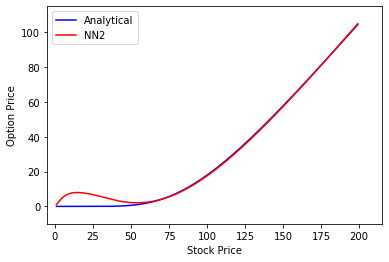

In [12]:
def train_net_2():
    epoch = 1000
    batch = 256

    KK = tf.keras.backend
    batch_loss = 0
    cost = []
    learning_rate = 0.001


    optimizer = tf.optimizers.Adam(learning_rate = learning_rate)
    for j in range(epoch):
        if j % 100 == 0:
            learning_rate = learning_rate * 0.99
        with tf.GradientTape() as tape:
            batch_loss = Loss(pde_model, batch)
        grads = tape.gradient(batch_loss, pde_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, pde_model.trainable_variables))
        cost.append(KK.get_value(batch_loss))
        batch_loss = 0
        clear_output(wait=True)
        pde_predict(pde_model)
        if j % 100 == 0:
            print("Batch ", j+1, " Loss: ", KK.get_value(batch_loss),". Learning Rate: ",learning_rate)
            sleep(2)
train_net_2()   